In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json

In [2]:
def open_csv(file_path, folder, separator):
    """ Open a csv file in a inputs subfolder given a file name, a folder and a separator. """
    if folder != 'inputs':
        path = os.path.join(os.pardir, 'inputs', folder, file)
    else:
        path = os.path.join(os.pardir, 'inputs', file)
    return pd.read_csv(path , sep = separator, engine='python')

In [3]:
def to_date_time(df, column):
    """ Convert a dataframe column to datetime and set it as index. """
    df[[column]] = pd.DataFrame(pd.to_datetime(df[column], format='%d.%m.%Y %H:%M'))
    df.set_index(column, inplace = True)

In [4]:
def time_delta(delta):
    """ Get a timedelta object from a given string with a fomat hrs_min_sec as "00:00:00" hours 
        minutes seconds.
    """
    t = datetime.strptime(delta,"%H:%M:%S")
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

In [9]:
def weather_data_to_df(file, period_start, period_end, timestep):
    """ Create a dataframe from a csv file of meteorological data for a given period and with a 
        given timestep
    """
    df = open_csv(file, 'profiles', 'weather', ';')
    to_date_time(df, 'Date')
    
    df = df.truncate(before = period_start, after = period_end)
    
    # Sum over Irradiance values: units of Irradiance are now kWh/m^2/h = kW/m^2
    df = df.resample(time_delta(timestep)).agg({'Irradiance': np.sum, 'Temperature': np.mean})
    df['Irradiance'] /= 1000 
    return df

In [10]:
def reshape_day_hour(hourly_indexed_list, Days, Hours):
    """ Reshape a list with hourly index to a list of list with daily and hour 
    in day index """
    return (np.reshape(hourly_indexed_list, (len(Days), len(Hours))))

In [11]:
# Weather parameters for a summer day at Liebensberg
file = 'meteo_Liebensberg_10min.csv'
start, stop, time_Step, Date_format = '2019-01-01', '2020-01-01', '01:00:00', '%Y-%m-%d'
df_weather = weather_data_to_df(file, start, stop, time_Step)
df_weather.drop(df_weather.tail(1).index,inplace=True)

dt_start = datetime.strptime(start, Date_format)
dt_end = datetime.strptime(stop, '%Y-%m-%d')

# Day index
Days = list(range((dt_end - dt_start).days))

# Hour index
Hours = list(range(0,24))

# External temperature - format Ext_T[Day_index,Hour_index]
Ext_T = reshape_day_hour((df_weather['Temperature'].values), Days, Hours)

# Global irradiance
Irradiance = reshape_day_hour((df_weather['Irradiance'].values), Days, Hours)

TypeError: open_csv() takes 3 positional arguments but 4 were given

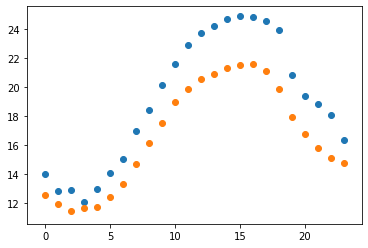

In [8]:
plt.scatter(Hours, Ext_T[151])
plt.scatter(Hours, Ext_T[150])

In [11]:
X = np.zeros((len(Days), 48))
for d in Days:
    X[d] = np.concatenate((Ext_T[d], Irradiance[d]), axis=0)

In [12]:
with open(os.path.join('jsons', 'clusters.json'), 'r') as json_file:
    data = json.load(json_file)
labels = data['labels']
closest = data['closest']
set_of_labels = {}
for i in labels.keys():
    set_of_labels[i] = set(labels[i])

In [13]:
def inspect(l):
    print('type: {}, len: {}, min: {}, max: {}'.format(type(l), len(l), min(l), max(l)))
inspect(labels['10'])

type: <class 'list'>, len: 365, min: 0, max: 9


In [14]:
# clustered_days[Cluster][Days][0: Ext_t, 1: Irradiance][Hours]
clustered_days = {}
for d in Days:
    typical_period = labels['20'][d]
    try:
        a = clustered_days[typical_period]
    except:
        clustered_days[typical_period] = []
    clustered_days[typical_period].append([Ext_T[d], Irradiance[d]])

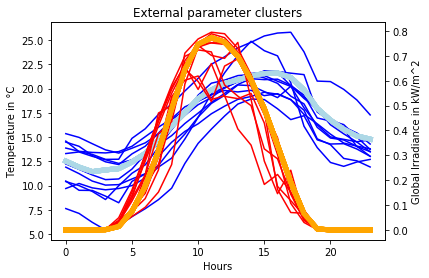

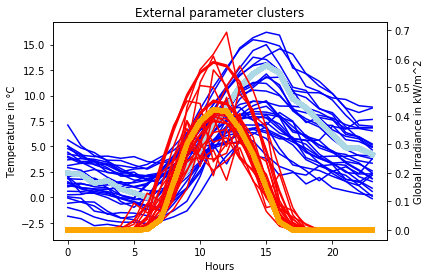

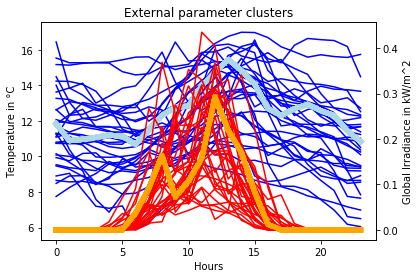

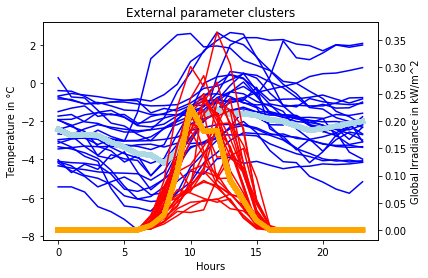

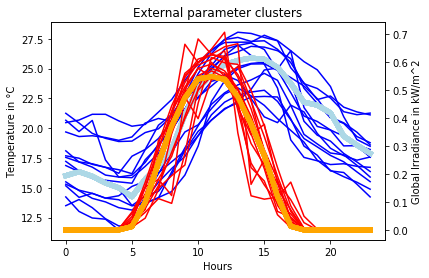

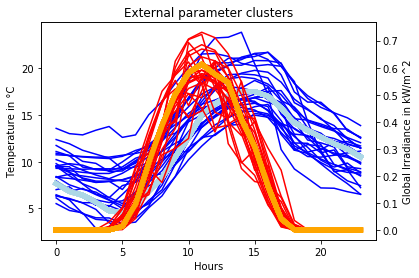

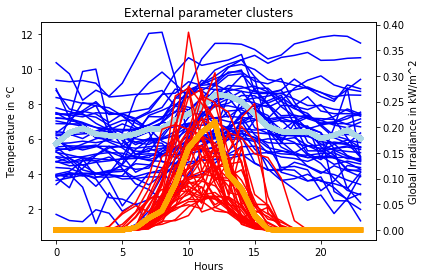

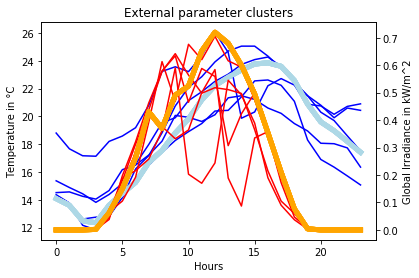

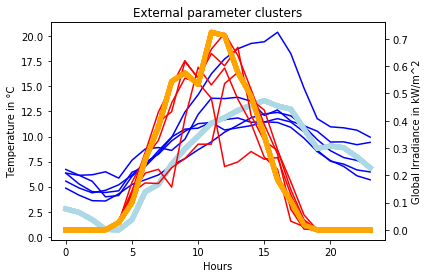

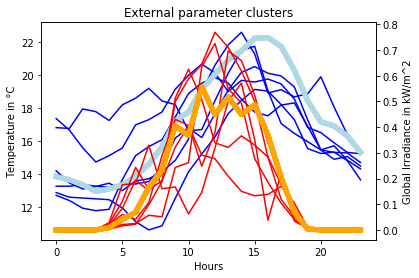

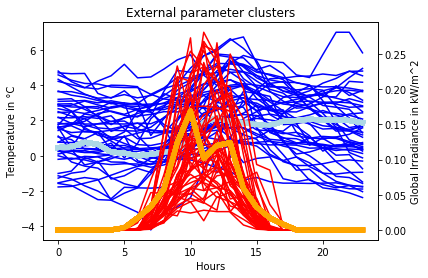

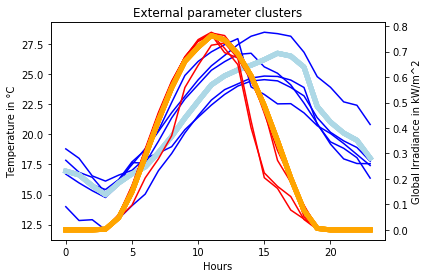

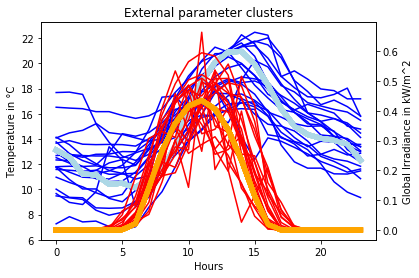

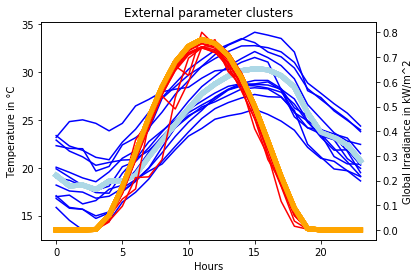

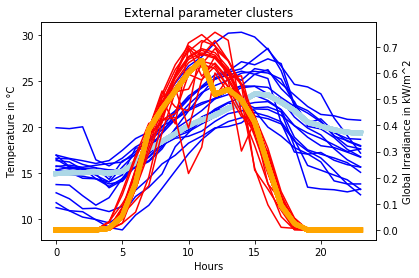

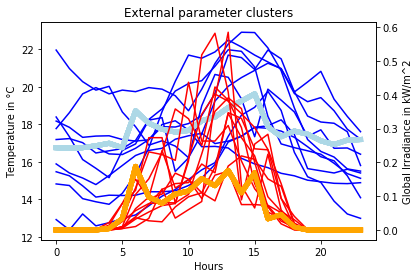

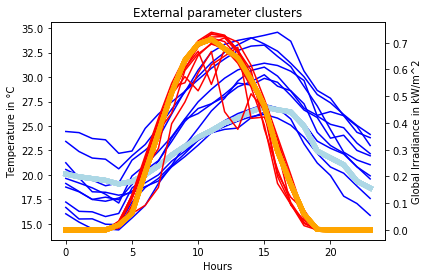

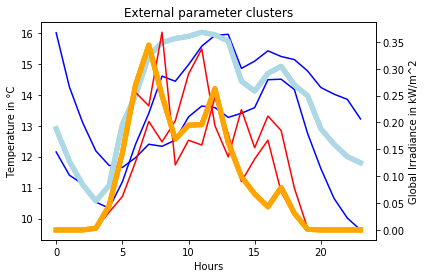

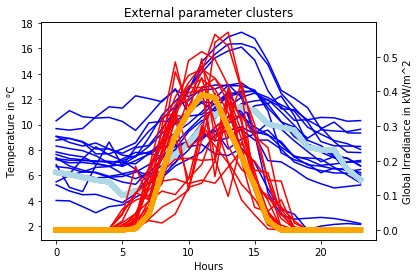

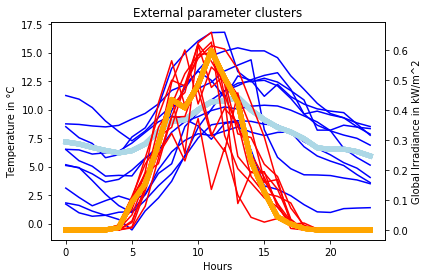

In [14]:
for i in set_of_labels['20']:
    fig, ax1 = plt.subplots()
    plt.title('External parameter clusters')
    ax1.set_xlabel('Hours')
    ax1.set_ylabel('Temperature in °C')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Global Irradiance in kW/m^2')
    for d in range(len(clustered_days[i])):
        
        ax1.plot(Hours, clustered_days[i][d][0], label=f'Typical day nbr {i}', c='blue')
        ax2.plot(Hours, clustered_days[i][d][1], label=f'Typical day nbr {i}', c='red')
        
        ax1.plot(Hours, Ext_T[closest['20'][i]], label=f'Typical day nbr {i}', c='lightblue', linewidth=5)
        ax2.plot(Hours, Irradiance[closest['20'][i]], label=f'Typical day nbr {i}', c='orange', linewidth=5)
        
        #ax1.legend(loc='center left') 
        #ax2.legend(loc='center right')


## Calculate mean square error

In [15]:
MSE_n = {}
for i in set_of_labels['20']:
    MSE_n[i] = {0:[], 1:[]}
    medioid = closest['20'][i]
    
    med_T = Ext_T[medioid]
    med_Irr = Irradiance[medioid]
    for d in range(len(clustered_days[i])):
        exact_T = clustered_days[i][d][0]
        exact_Irr = clustered_days[i][d][1]
        
        MSE_n[i][0].append((exact_T - med_T)**2)
        MSE_n[i][1].append((exact_Irr - med_Irr)**2)

In [16]:
MSE_T = 0
for i in set_of_labels['20']:
    for d in range(len(clustered_days[i])):
        MSE_T += sum(MSE_n[i][0][d])/24
MSE_T/365

5.017952149923898

In [17]:
len(MSE_n[10][0])

47

In [18]:
A = np.array([0.2,0.58])
B = np.array([0.1,0.336])

In [19]:
A - B

array([0.1  , 0.244])

In [20]:
exact_T

array([ 8.75      ,  8.7       ,  8.56666667,  8.48333333,  8.61666667,
        9.16666667,  9.66666667, 10.5       , 11.68333333, 12.16666667,
       13.36666667, 12.56666667, 11.05      , 12.95      , 12.56666667,
       11.16666667, 12.21666667, 11.13333333, 10.48333333, 10.06666667,
        9.86666667,  9.73333333,  8.73333333,  7.75      ])

In [21]:
med_T

array([ 7.16666667,  6.98333333,  6.68333333,  6.41666667,  6.2       ,
        6.4       ,  6.98333333,  8.1       ,  8.95      ,  9.1       ,
        9.98333333, 10.68333333, 10.75      , 11.08333333,  9.96666667,
        9.11666667,  8.45      ,  8.03333333,  7.45      ,  6.65      ,
        6.51666667,  6.53333333,  6.31666667,  5.93333333])

In [22]:
(exact_T - med_T)**2

array([ 2.50694444,  2.94694444,  3.54694444,  4.27111111,  5.84027778,
        7.65444444,  7.20027778,  5.76      ,  7.47111111,  9.40444444,
       11.44694444,  3.54694444,  0.09      ,  3.48444444,  6.76      ,
        4.2025    , 14.18777778,  9.61      ,  9.20111111, 11.67361111,
       11.2225    , 10.24      ,  5.84027778,  3.30027778])

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale 

In [230]:
MSE = {}
MSE_T, MSE_Irr = {}, {}
for n in range(0,100):
    with open(os.path.join('jsons', f'clusters_6_{n}.json'), 'r') as json_file:
        data = json.load(json_file)
    labels = data['labels']
    closest = data['closest']
    set_of_labels = {}
    for i in labels.keys():
        set_of_labels[i] = set(labels[i])
    list_of_keys = list(set_of_labels.keys())

    clustered_days = {}
    for k in list_of_keys:
        # clustered_days[key][Cluster][Days][0: Ext_t, 1: Irradiance][Hours]
        clustered_days[k] = {}
        for d in Days:
            typical_period = labels[k][d]
            try:
                a = clustered_days[typical_period]
            except:
                clustered_days[k][typical_period] = []
            clustered_days[k][typical_period].append([Ext_T[d], Irradiance[d]])

    MSE[n] = {}
    for k in list_of_keys:
        y_true, y_predict = {0:[], 1:[]}, {0:[], 1:[]}
        for i in set_of_labels[k]:
            medioid = closest[k][i]

            med_T = Ext_T[medioid]
            med_Irr = Irradiance[medioid]
            for d in range(len(clustered_days[k][i])):
                exact_T = clustered_days[k][i][d][0]
                exact_Irr = clustered_days[k][i][d][1]

                y_true[0].append(exact_T)
                y_predict[0].append(med_T)

                y_true[1].append(exact_Irr)
                y_predict[1].append(med_Irr)

        MSE[n][k] = {}
        for i in [0,1]:        
            #y_true[i], y_predict[i] = scale(y_true[i]), scale(y_predict[i])
            MSE[n][k][i] = mean_squared_error(y_true[i], y_predict[i])

    MSE_T[n], MSE_Irr[n] = [], []
    for k in list_of_keys:
        MSE_T[n].append(MSE[n][k][0])
        MSE_Irr[n].append(MSE[n][k][1])

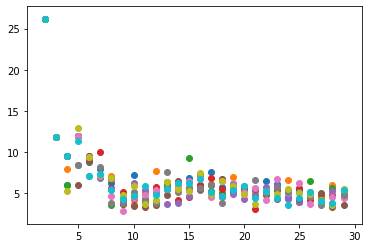

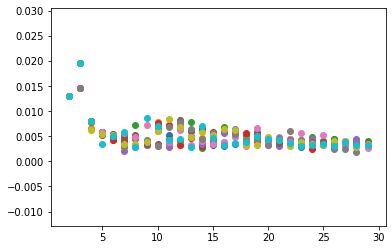

In [149]:
number_of_clusters = np.arange(2,len(list_of_keys) + 2)
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_T[n])
plt.show()
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_Irr[n])
plt.show()

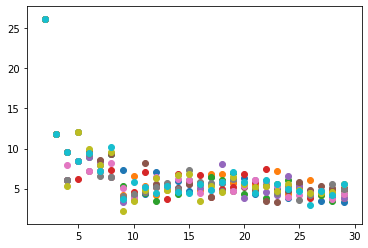

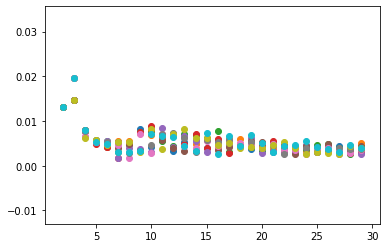

In [147]:
number_of_clusters = np.arange(2,len(list_of_keys) + 2)
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_T[n])
plt.show()
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_Irr[n])
plt.show()

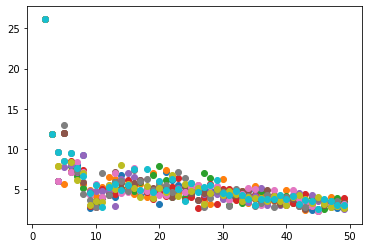

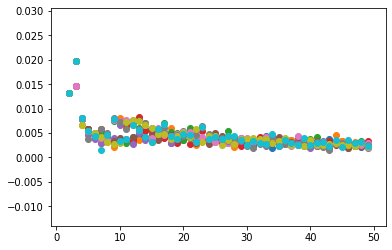

In [151]:
number_of_clusters = np.arange(2,len(list_of_keys) + 2)
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_T[n])
plt.show()
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_Irr[n])
plt.show()

In [27]:
MSE_T[n][np.argmin(MSE_T[n])]

2.585290637860083

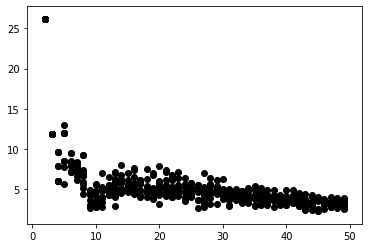

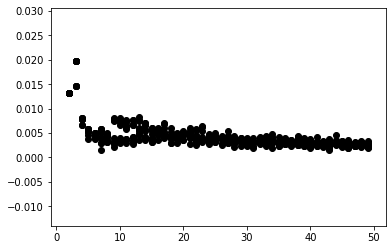

In [33]:
number_of_clusters = np.arange(2,len(list_of_keys) + 2)
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_T[n], c='black')
#for n in range(0,10):    
#    plt.scatter(np.argmin(MSE_T[n]), MSE_T[n][np.argmin(MSE_T[n])], c='red')
plt.show()
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_Irr[n], c ='black')
#for n in range(0,10):
#    plt.scatter(np.argmin(MSE_Irr[n]), MSE_Irr[n][np.argmin(MSE_Irr[n])], c='red')
plt.show()

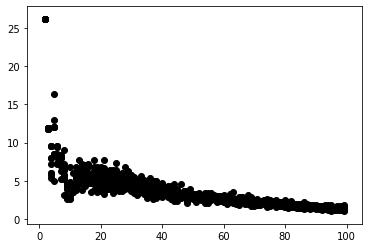

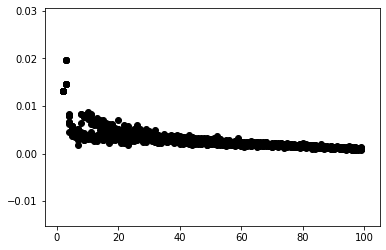

In [104]:
number_of_clusters = np.arange(2,len(list_of_keys) + 2)
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_T[n], c='black')
#for n in range(0,10):    
#    plt.scatter(np.argmin(MSE_T[n]), MSE_T[n][np.argmin(MSE_T[n])], c='red')
#plot_minima_index(A_T)
plt.show()
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_Irr[n], c ='black')
#for n in range(0,10):
#    plt.scatter(np.argmin(MSE_Irr[n]), MSE_Irr[n][np.argmin(MSE_Irr[n])], c='red')
plt.show()

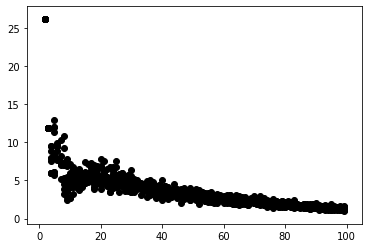

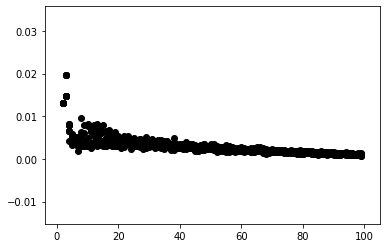

In [106]:
number_of_clusters = np.arange(2,len(list_of_keys) + 2)
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_T[n], c='black')
#for n in range(0,10):    
#    plt.scatter(np.argmin(MSE_T[n]), MSE_T[n][np.argmin(MSE_T[n])], c='red')
#plot_minima_index(A_T)
plt.show()
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_Irr[n], c ='black')
#for n in range(0,10):
#    plt.scatter(np.argmin(MSE_Irr[n]), MSE_Irr[n][np.argmin(MSE_Irr[n])], c='red')
plt.show()

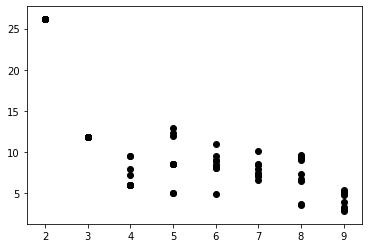

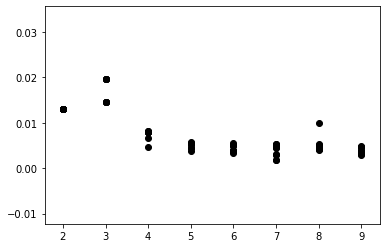

In [126]:
number_of_clusters = np.arange(2,len(list_of_keys) + 2)
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_T[n], c='black')
#for n in range(0,10):    
#    plt.scatter(np.argmin(MSE_T[n]), MSE_T[n][np.argmin(MSE_T[n])], c='red')
#plot_minima_index(A_T)
plt.show()
for n in range(0,10):
    plt.scatter(number_of_clusters, MSE_Irr[n], c ='black')
#for n in range(0,10):
#    plt.scatter(np.argmin(MSE_Irr[n]), MSE_Irr[n][np.argmin(MSE_Irr[n])], c='red')
plt.show()

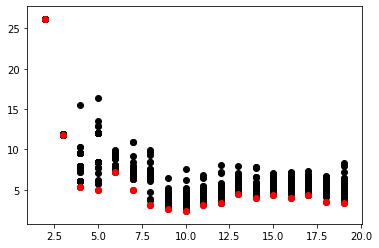

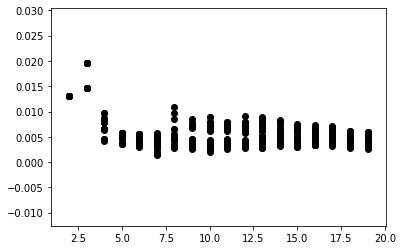

In [134]:
number_of_clusters = np.arange(2,len(list_of_keys) + 2)
for n in range(0,30):
    plt.scatter(number_of_clusters, MSE_T[n], c='black')
plot_minima_index(A_T)
plt.show()
for n in range(0,30):
    plt.scatter(number_of_clusters, MSE_Irr[n], c ='black')
plt.show()

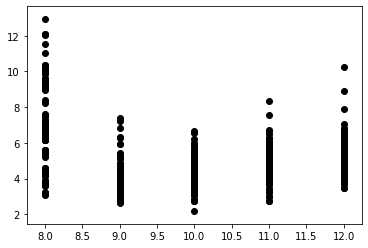

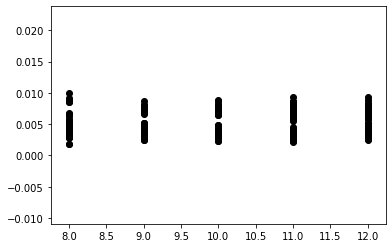

In [231]:
number_of_clusters = np.arange(8,len(list_of_keys) + 8)
for n in range(0,100):
    plt.scatter(number_of_clusters, MSE_T[n], c='black')
plt.show()
for n in range(0,100):
    plt.scatter(number_of_clusters, MSE_Irr[n], c ='black')
plt.show()

In [133]:
def plot_minima_index(A):
    plt.scatter( np.amin(A), minimas[k], color ='r')

In [189]:
np.argmin(A_T)/30

0.8666666666666667

In [153]:
np.shape(A_T)
30*18

540

In [236]:
A_T = np.zeros((100,len(MSE_T[0])))
A_Irr = A_T.copy()

In [237]:
for n in range(0,100):
    A_T[n] = MSE_T[n]
    A_Irr[n] = MSE_Irr[n]

In [242]:
def minima_index(A):
    minimas = np.amin(A, axis=0)
    argminimas = np.argmin(A, axis=0)
    for k in range(0, len(minimas)):
        print((argminimas[k], k + 8), ' :', minimas[k])

In [243]:
minima_index(A_T)

(84, 8)  : 3.0715002893518517
(14, 9)  : 2.658443930041153
(28, 10)  : 2.1701828703703714
(1, 11)  : 2.7472369528619534
(32, 12)  : 3.458321759259259


In [249]:
A_Irr[28,2]

0.0037750333333333333

In [244]:
minima_index(A_Irr)

(94, 8)  : 0.001804802083333333
(60, 9)  : 0.002386462962962963
(43, 10)  : 0.0022761041666666663
(97, 11)  : 0.002096155303030303
(79, 12)  : 0.0023896979166666663


In [158]:
minima_index(A_T)

(18, 6)  : 3.0715002893518517
(15, 7)  : 2.6672890946502066
(27, 8)  : 2.377373842592593
(12, 9)  : 3.1021917087542086
(23, 10)  : 3.3028742283950607
(21, 12)  : 4.013272982804233
(11, 14)  : 3.9582407407407403
(21, 16)  : 3.5438811728395065
(29, 17)  : 3.3716532651072115


In [159]:
minima_index(A_Irr)

(22, 4)  : 0.002952243055555555
(17, 5)  : 0.0014127023809523808
(14, 6)  : 0.0028528958333333327
(9, 7)  : 0.0025367129629629624
(15, 8)  : 0.0019412541666666667
(9, 9)  : 0.0025258598484848484
(19, 10)  : 0.0027079270833333335
(8, 11)  : 0.002739701923076923
(19, 13)  : 0.0029290500000000003
(14, 16)  : 0.0027445856481481483
(4, 17)  : 0.0026751293859649124


In [73]:
minimas[0]

26.13006365740741

In [83]:
np.amin(A_T, axis=0)

array([26.13006366, 11.8327392 ,  5.32151331,  4.96313889,  7.14417438,
        5.28957011,  3.14797309,  2.65844393,  2.6705081 ,  3.49200337,
        3.82486497,  4.56681446,  3.83531994,  4.36946373,  4.64721499,
        3.58906931,  3.79039223,  3.48103131,  3.6399213 ,  3.26961089,
        3.89760364,  3.97170139,  3.37641686,  3.95876204,  3.68457399,
        3.6684255 ,  3.86623595,  4.36466395,  3.62313117,  3.41621677,
        3.1383572 ,  3.53764134,  3.21977328,  2.77950628,  2.98318191,
        2.56544545,  2.76245492,  3.20762999,  2.83991088,  3.15460027,
        2.93124614,  2.57003741,  2.41297612,  2.37773277,  2.6801872 ,
        2.89772902,  2.11473621,  2.95289092,  2.66772315,  2.19510054,
        2.62910256,  2.46852441,  2.07590278,  2.10049242,  2.43896226,
        2.5680117 ,  2.25627654,  2.37681909,  2.20922454,  1.94289485,
        2.28789128,  2.06368699,  2.01695059,  1.86543234,  2.26987549,
        2.00323521,  1.99036067,  1.74285511,  1.69214666,  1.78

In [86]:
np.argmin(A_T, axis=0)

array([0, 1, 8, 7, 1, 7, 8, 4, 0, 5, 5, 4, 4, 1, 9, 1, 6, 7, 4, 4, 9, 1,
       5, 3, 7, 8, 4, 4, 8, 5, 4, 0, 1, 0, 6, 4, 3, 7, 4, 2, 0, 9, 1, 6,
       8, 8, 3, 8, 3, 8, 7, 1, 1, 9, 2, 0, 1, 6, 3, 1, 3, 8, 2, 2, 9, 9,
       8, 2, 3, 2, 0, 8, 7, 5, 0, 2, 2, 5, 4, 4, 2, 5, 3, 8, 1, 1, 1, 3,
       2, 6, 3, 4, 8, 6, 2, 4, 7, 3], dtype=int64)

In [89]:
min(A_T[0])

1.1816788252899364

In [123]:
minima_index(A_Irr)

(1, 5)  : 0.0017178988095238091
(9, 6)  : 0.0032661979166666664
(4, 7)  : 0.002813347222222222
(9, 8)  : 0.003025033333333333
(0, 9)  : 0.0030275265151515148
(0, 10)  : 0.0027504131944444446
(8, 11)  : 0.002748913461538461
(2, 13)  : 0.002882811111111111
(8, 15)  : 0.002311328431372549
(8, 16)  : 0.002929789351851852
(0, 17)  : 0.002961964912280702
(5, 18)  : 0.00304526875
(4, 19)  : 0.0022003194444444444
(0, 20)  : 0.0022357102272727272
(1, 21)  : 0.0018571340579710144
(0, 22)  : 0.002698567708333333
(6, 23)  : 0.00257348
(6, 24)  : 0.002831490384615385
(2, 25)  : 0.0032066975308641978
(5, 26)  : 0.002377063988095238
(4, 27)  : 0.0024823419540229885
(4, 28)  : 0.0030636791666666663
(9, 29)  : 0.0027354704301075267
(8, 30)  : 0.0024387721354166667
(7, 31)  : 0.002162875
(8, 32)  : 0.0022022242647058822
(0, 33)  : 0.0026410285714285713
(5, 34)  : 0.002404565972222222
(4, 35)  : 0.0027207871621621623
(3, 36)  : 0.002193461622807017
(5, 37)  : 0.0024214070512820515
(4, 38)  : 0.0019808572

In [124]:
minima_index(A_T)

(8, 6)  : 3.147973090277778
(4, 7)  : 2.658443930041153
(0, 8)  : 2.6705081018518517
(5, 9)  : 3.492003367003367
(5, 10)  : 3.8248649691358025
(4, 12)  : 3.835319940476191
(1, 13)  : 4.369463734567901
(1, 15)  : 3.589069308278867
(6, 16)  : 3.7903922325102877
(7, 17)  : 3.4810313109161797
(4, 18)  : 3.639921296296297
(4, 19)  : 3.2696108906525576
(9, 20)  : 3.8976036405723904
(1, 21)  : 3.971701388888889
(5, 22)  : 3.3764168595679016
(3, 23)  : 3.9587620370370367
(7, 24)  : 3.6845739850427357
(8, 25)  : 3.6684254972565156
(4, 26)  : 3.866235945767196
(4, 27)  : 4.3646639527458495
(8, 28)  : 3.623131172839507
(5, 29)  : 3.4162167712066904
(4, 30)  : 3.1383572048611117
(0, 31)  : 3.5376413439955114
(1, 32)  : 3.219773284313726
(0, 33)  : 2.7795062830687836
(6, 34)  : 2.9831819058641975
(4, 35)  : 2.565445445445445
(3, 36)  : 2.7624549220272905
(7, 37)  : 3.2076299857549864
(4, 38)  : 2.8399108796296297
(2, 39)  : 3.1546002710027103
(0, 40)  : 2.931246141975309
(9, 41)  : 2.57003741386735